In [1]:
#Import Statements
import numpy as np 
from matplotlib import pyplot as plt 
import os, sys
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import models
from torchsummary import summary
from scipy.stats import t
import math
from prediction_classes import fx_data_set,NeuralNetwork
from webscrape import scraper
from prediction import form_prediction

In [2]:
if __name__=="__main__":
    #retrieve data
    scrape=True
    while scrape:
        try:
            open_data,close_data,high_data,low_data,td_days=scraper('1H')
            scrape=False
        except:
            print('Error obtaining data')
            pass
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    #form prediction and obtain trade size
    trade_size,model,fx_dataset,max_arr,min_arr=form_prediction(open_data,close_data,high_data,low_data,td_days,device)
    #End core code
    
    

<built-in method type of Tensor object at 0x0000023E8BD90AE0>


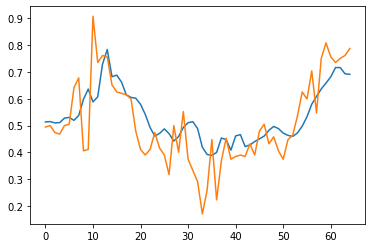

In [12]:
num_prec=5
#Testing and eval
model.eval()
model.cpu()
device="cpu"
pred_arr=np.zeros(fx_dataset.__len__())
y_arr=np.zeros(fx_dataset.__len__())
for i in range(0,fx_dataset.__len__()):
    x,y = fx_dataset.__getitem__(i)
    pred=model(x)
    pred_np=pred.cpu().detach().numpy() 
    pred_arr[i]=pred_np
    y_np=y.cpu().detach().numpy() 
    y_arr[i]=y_np
print(x.type)
plt.plot(pred_arr)
plt.plot(y_arr)

In [4]:
#delta interp
pred_delt=pred_arr-(close_data[num_prec-1:len(close_data)-1]-min(min_arr))/(max(max_arr)-min(min_arr)) 
act_delt=y_arr-(close_data[num_prec-1:len(close_data)-1]-min(min_arr))/(max(max_arr)-min(min_arr))
plt.plot(pred_delt)
plt.plot(act_delt)
perc_correct=0
for i in range(0,len(pred_delt)):
    if pred_delt[i]*act_delt[i]>0:
        perc_correct+=100*(1/len(pred_delt))

print(trade_size)

In [23]:
pred_set=np.zeros((1,int(4*num_prec),1),dtype='float32')
pred_set[0,0:num_prec,0]=(open_data[len(open_data)-num_prec:len(open_data)]-min(min_arr))/(max(max_arr)-min(min_arr))
pred_set[0,num_prec:int(2*num_prec),0]=(close_data[len(open_data)-num_prec:len(open_data)]-min(min_arr))/(max(max_arr)-min(min_arr))
pred_set[0,int(2*num_prec):int(3*num_prec),0]=(high_data[len(open_data)-num_prec:len(open_data)]-min(min_arr))/(max(max_arr)-min(min_arr))
pred_set[0,int(3*num_prec):int(4*num_prec),0]=(low_data[len(open_data)-num_prec:len(open_data)]-min(min_arr))/(max(max_arr)-min(min_arr))
pred_set=torch.from_numpy(pred_set)
prediction_val=model(pred_set)
final_actual_val=(close_data[-1]-min(min_arr))/(max(max_arr)-min(min_arr))
if prediction_val-final_actual_val<0:
    direction='short'
else:
    direction='long'

tensor([[0.6886]], grad_fn=<UnsqueezeBackward0>)
0.7879581151832455
short


In [5]:

#try altering num_prec
#original: 5
#try 8
#make program flexible enough to accept variable num_prec

#try designing custom loss function that penalizes more heavily for incorrect signs 

#try reintroducing td:
    
#consider using batch normalization and reintroducing td 
    #should elim problems with td 

#add try except to web scrape

#add actual prediction value 

#remove all print statements